In this notebook, I'll be performing semantic analysis on hotel reviews from TripAdvisor using 2 different approaches:

1. With machine learning models using sklearn
2. With deep neural network using tensorflow

In [1]:
%pip install nltk

In [2]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

## Loading Dataset

In [3]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


There is **no null values** in this dataset

## Data Visualization

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

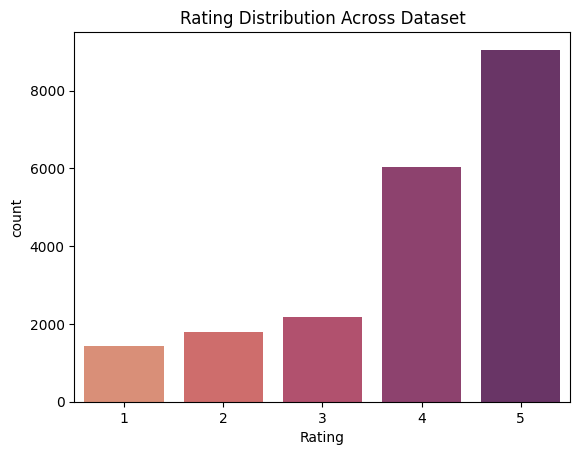

In [5]:
sns.countplot(data=df, x='Rating', palette='flare').set_title('Rating Distribution Across Dataset')

In [6]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


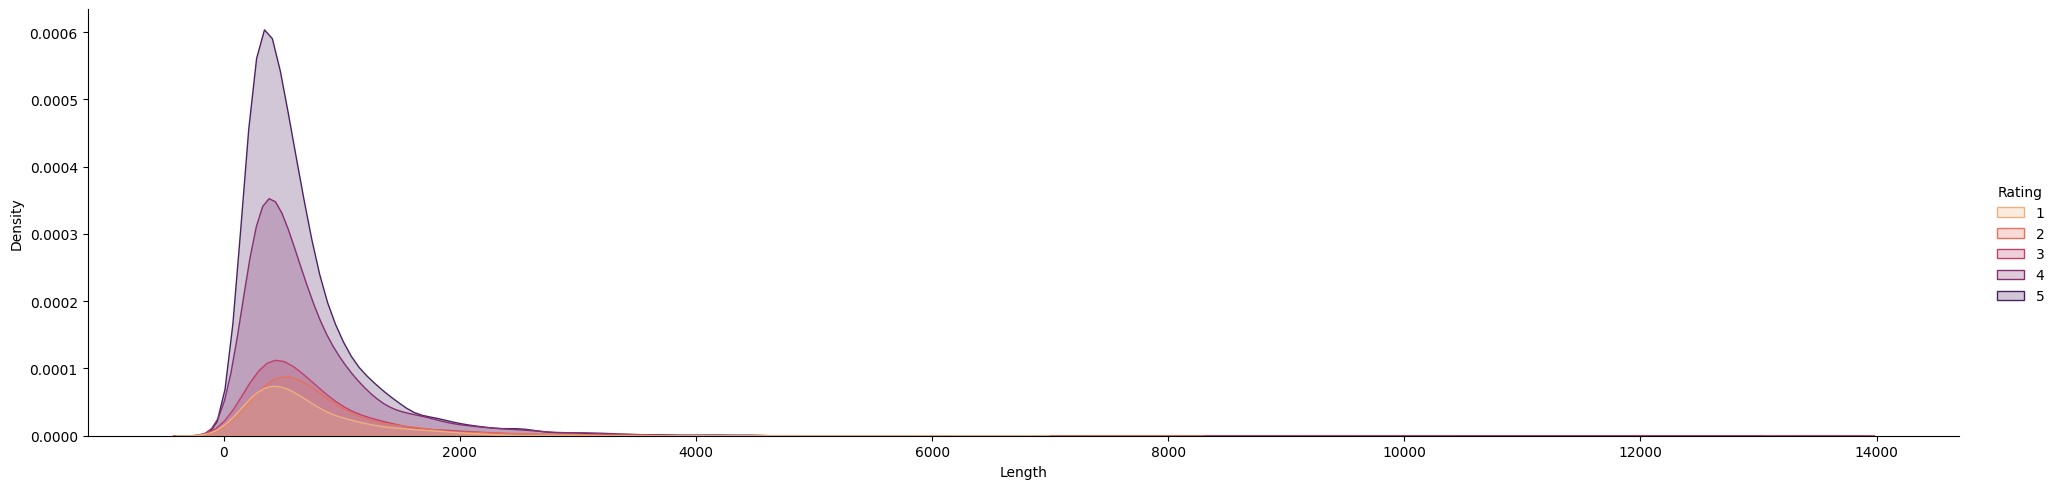

In [7]:
sns.displot(data=df, x='Length', hue='Rating', palette='flare', kind='kde', fill=True, aspect=4)

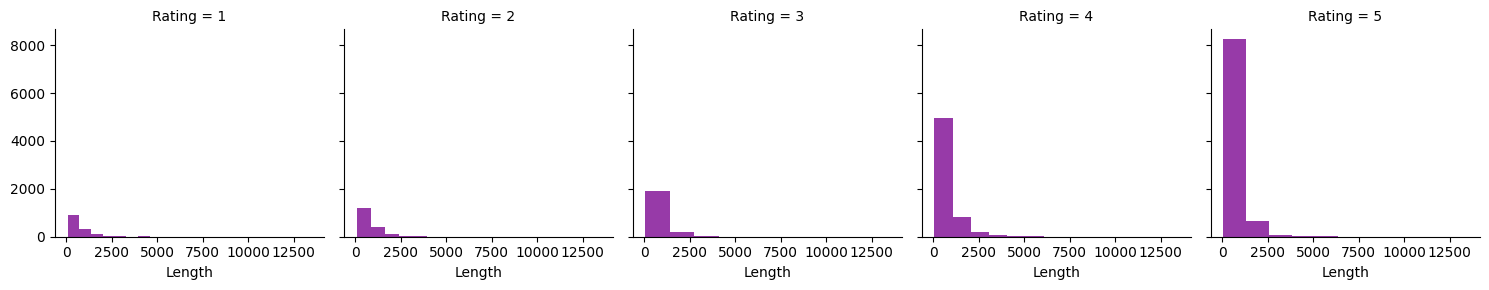

In [8]:
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Length', color='#973aa8')

<ipython-input-9-bfb0fb9b3000>:1: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df, x='Rating', y='Length', palette='flare', alpha=0.3)


<Axes: xlabel='Rating', ylabel='Length'>

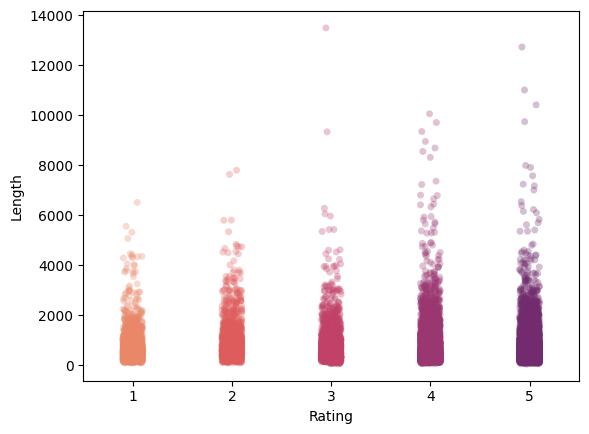

In [9]:
sns.stripplot(data=df, x='Rating', y='Length', palette='flare', alpha=0.3)

From above plot we can say that **the higher the rating of the hotel, the more likely the visitors wrote a long review**

## Text Preprocessing

In [10]:
# change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Netral'
    else:
        return 'Bad'

In [11]:
df['Rating'] = df['Rating'].apply(rating)

In [12]:
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,Good,593
1,ok nothing special charge diamond member hilto...,Bad,1689
2,nice rooms not 4* experience hotel monaco seat...,Netral,1427
3,"unique, great stay, wonderful time hotel monac...",Good,600
4,"great stay great stay, went seahawk game aweso...",Good,1281


In [13]:
# Total word in dataset before cleaning
length = df['Length'].sum()

## Stemming vs Lemmatization

In [14]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
print('Original:')
print(df['Review'][0])
print()

sentence = []
for word in df['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath produc

There are some difference among those 3 sentences, for instance:
* Original -> got, arrived
* Stemming -> got, arriv
* Lemmatization -> get, arrive

Using Lemmatization in order to get the base form of the word

In [16]:
def cleaning(text):
    # remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

    # remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]

    # lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [17]:
df['Review'] = df['Review'].apply(cleaning)

In [18]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()

print('Total text length before cleaning: {}'.format(length))
print('Total text length after cleaning: {}'.format(new_length))

Total text length before cleaning: 14853861
Total text length after cleaning: 13543965


In [19]:
df.to_csv('cleaned_df.csv', index=False)

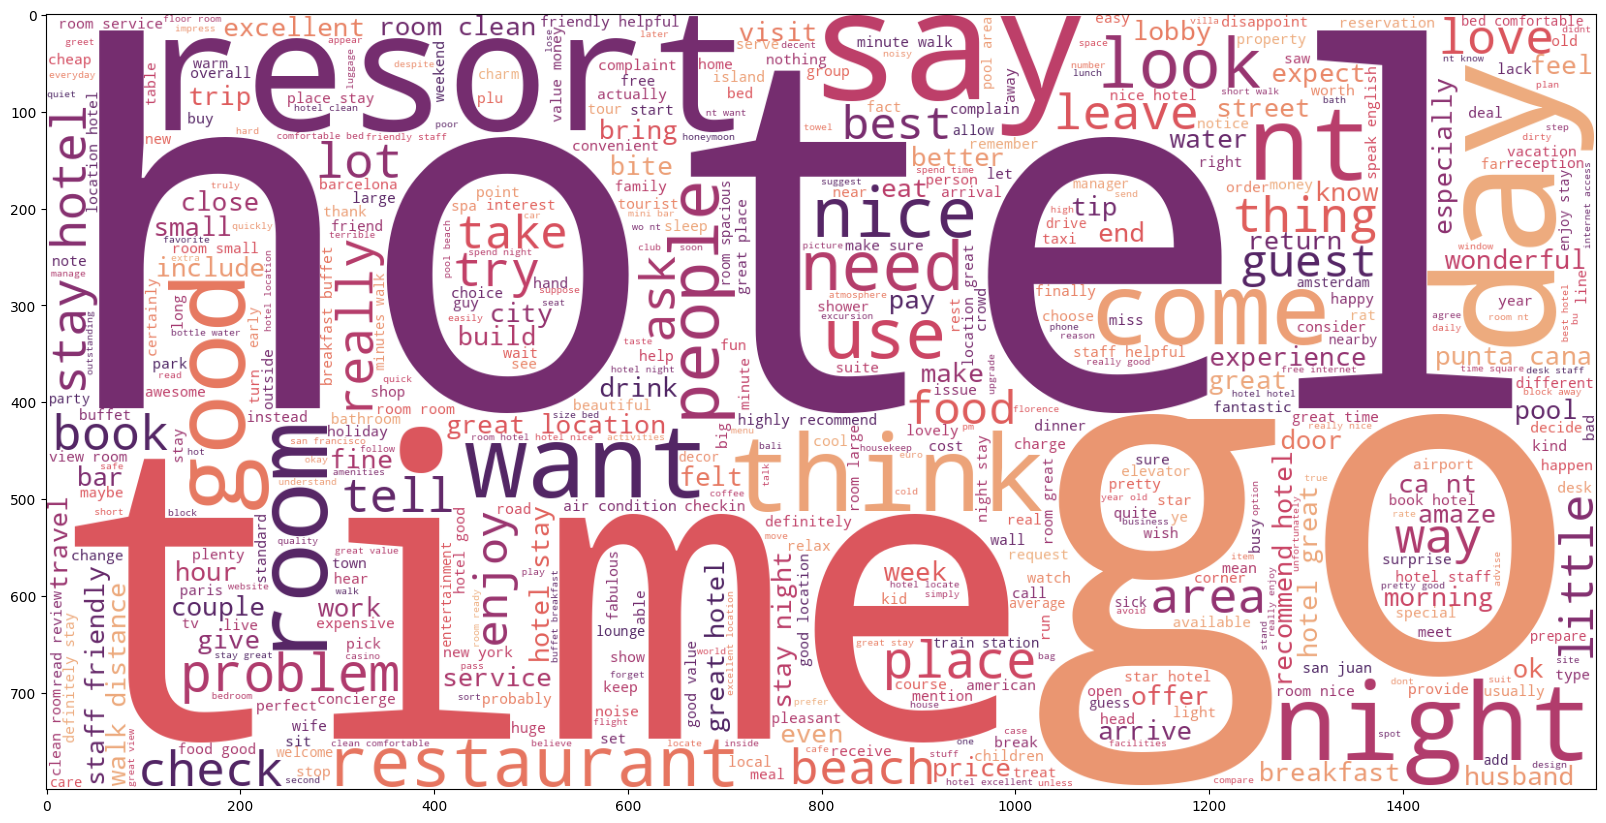

In [20]:
# see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df['Review']))

plt.imshow(wc)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

## Sklearn Model

In [22]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [23]:
pickle.dump(tfid, open('tfidf.pkl', 'wb'))

In [24]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression(max_iter=1000),
          KNeighborsClassifier(),
          BernoulliNB()]

In [25]:
accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tfid_matrix, y_train, scoring='accuracy',
                               cv=StratifiedKFold(10)).mean()
    accuracy.append(cross_val)

In [26]:
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC',
         'LogisticRegression', 'KNeighborsClassifier', 'BernoulliNB']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
acc

,Model,Accuracy
0,DecisionTreeClassifier,0.737554
1,RandomForestClassifier,0.779405
2,SVC,0.852855
3,LogisticRegression,0.855600
4,KNeighborsClassifier,0.787092
5,BernoulliNB,0.755063


Since Logistic Regression performs better than other models in this case, we will use it to train our model

In [27]:
log = LogisticRegression(max_iter=1000)
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

In [28]:
pickle.dump(log, open('ml_model.pkl', 'wb'))

In [29]:
ml = pickle.load(open('ml_model.pkl','rb'))
tfidf = pickle.load(open('tfidf.pkl','rb'))
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfidf.transform([clean_text])
    pred_proba = ml.predict_proba(tfid_matrix)
    idx = np.argmax(pred_proba)
    pred = ml.classes_[idx]

    return pred, pred_proba[0][idx]

ml_predict('poor room service')

('Bad', 0.9605525877700902)

In [30]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 487  114   45]
 [  30 2951   36]
 [  83  266   87]]
              precision    recall  f1-score   support

         Bad       0.81      0.75      0.78       646
        Good       0.89      0.98      0.93      3017
      Netral       0.52      0.20      0.29       436

    accuracy                           0.86      4099
   macro avg       0.74      0.64      0.67      4099
weighted avg       0.84      0.86      0.84      4099



## TensorFlow Model

In [31]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 64974


In [32]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
pickle.dump(lb, open('label.pkl', 'wb'))

In [33]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(8, kernel_regularizer=l2(0.001),
                                                          bias_regularizer=l2(0.001), activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           519792    
                                                                 
 bidirectional (Bidirection  (None, 32)                3200      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                        

In [36]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels))

Epoch 1/5
513/513 [==============================] - 966s 2s/step - loss: 0.8072 - accuracy: 0.7335 - val_loss: 0.6991 - val_accuracy: 0.7360
Epoch 2/5
513/513 [==============================] - 937s 2s/step - loss: 0.7319 - accuracy: 0.7359 - val_loss: 0.6370 - val_accuracy: 0.7360
Epoch 3/5
513/513 [==============================] - 944s 2s/step - loss: 0.6689 - accuracy: 0.7362 - val_loss: 0.5841 - val_accuracy: 0.7360
Epoch 4/5
513/513 [==============================] - 947s 2s/step - loss: 0.6382 - accuracy: 0.7365 - val_loss: 0.5695 - val_accuracy: 0.7360
Epoch 5/5
513/513 [==============================] - 946s 2s/step - loss: 0.5854 - accuracy: 0.7365 - val_loss: 0.5420 - val_accuracy: 0.7360


<Axes: >

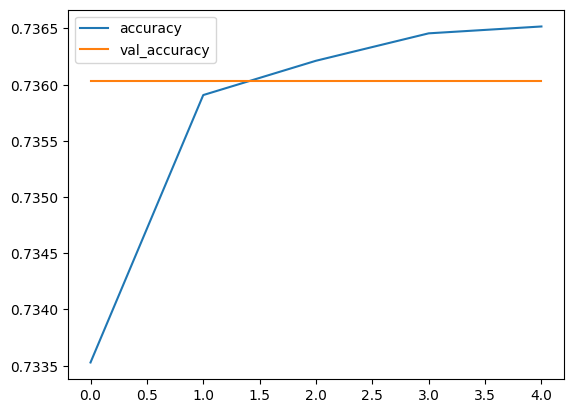

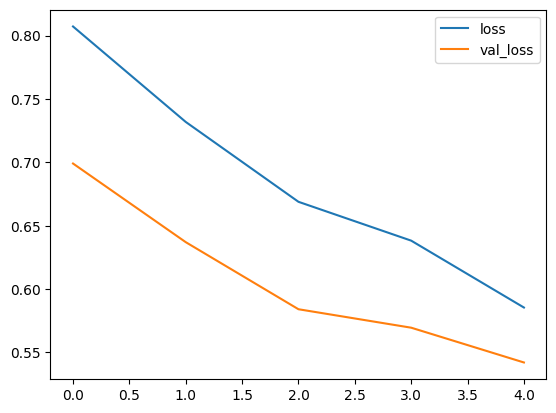

In [37]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [38]:
pred2 = model.predict(test_padded)

129/129 [==============================] - 20s 147ms/step


In [39]:
true_labels = np.argmax(test_labels, axis=-1)
pred_labels = np.argmax(pred2, axis=-1)

In [40]:
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[   0  646    0]
 [   0 3017    0]
 [   0  436    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       646
           1       0.74      1.00      0.85      3017
           2       0.00      0.00      0.00       436

    accuracy                           0.74      4099
   macro avg       0.25      0.33      0.28      4099
weighted avg       0.54      0.74      0.62      4099



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
model.save('dl_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Prediction

In [42]:
# Logistic Regression
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfid.transform([clean_text])
    pred = log.predict(tfid_matrix)[0]

    return pred

# Deep Neural Network
def dl_predict(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]

    return result

In [43]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text)))
print('Prediction using DNN: {}'.format(dl_predict(text)))

Prediction using Logistic Regression: Good
1/1 [==============================] - 1s 871ms/step
Prediction using DNN: Good


In [44]:
text2 = 'Awful room services and slow wifi connection'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text2)))
print('Prediction using DNN: {}'.format(dl_predict(text2)))

Prediction using Logistic Regression: Bad
1/1 [==============================] - 0s 23ms/step
Prediction using DNN: Good


In [45]:
text3 = 'Hard to get here but the scenery is wonderful'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text3)))
print('Prediction using DNN: {}'.format(dl_predict(text3)))

Prediction using Logistic Regression: Good
1/1 [==============================] - 0s 22ms/step
Prediction using DNN: Good
